In [5]:
%pip install -q google-cloud-translate==3.15.3 protobuf==4.25.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install python-dotenv (quietly), then import and continue
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "python-dotenv"])

print("python-dotenv successfully installed. Continue to run the next cell.")


python-dotenv successfully installed. Continue to run the next cell.


In [3]:
# Sanity check to see if Google API Translate is successfully installed in the kernel
import os, pathlib, sys, json, importlib

print("Kernel Python:", sys.executable)  # make sure this matches your conda env 
print("GOOGLE_CLOUD_PROJECT =", os.getenv("GOOGLE_CLOUD_PROJECT"))
key = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
print("GOOGLE_APPLICATION_CREDENTIALS =", key)
print("Key file exists? ->", (pathlib.Path(key).exists() if key else None))

# Optional check of the key to confirm project_id
if key and pathlib.Path(key).exists():
    try:
        info = json.load(open(key))
        print("Key project_id =", info.get("project_id"))
    except Exception as e:
        print("Couldn't read key JSON:", e)

# Check the library is installed in THIS kernel
try:
    import google.cloud.translate_v3 as translate
    print("google-cloud-translate import: OK")
except Exception as e:
    print("google-cloud-translate import error:", e)


Kernel Python: c:\Python312\python.exe
GOOGLE_CLOUD_PROJECT = None
GOOGLE_APPLICATION_CREDENTIALS = None
Key file exists? -> None
google-cloud-translate import error: No module named 'google.cloud'


In [6]:


import os, pathlib, sys, subprocess

os.environ["GOOGLE_CLOUD_PROJECT"] = "inf791-translate"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/taongashe-muzvidziwa/Downloads/inf791-translate-9d9fa523e40e.json"

# (re)install client in this kernel if needed
try:
    import google.cloud.translate_v3 as translate
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "google-cloud-translate==3.15.3", "protobuf==4.25.3"])
    import google.cloud.translate_v3 as translate

print("Set env vars in-process; re-run the translator guard cell now.")


Set env vars in-process; re-run the translator guard cell now.


In [7]:
# Bootstrap environment and folders 
import os, pathlib, pandas as pd

ROOT = pathlib.Path.cwd()
DATA = ROOT / "data"
CACHE = ROOT / "cache"
RESULTS = ROOT / "results"

for p in (DATA, CACHE, RESULTS):
    p.mkdir(exist_ok=True)

# Optional: load .env if available
from dotenv import load_dotenv
if (ROOT / ".env").exists():
    load_dotenv(ROOT / ".env")
    print("Loaded .env successfully")
else:
    print("No .env file found (running in fallback mode)")

print(f"ROOT: {ROOT}")
print("Data folder →", DATA.exists())
print("Cache folder →", CACHE.exists())
print("Results folder →", RESULTS.exists())

print("Bootstrap OK")


No .env file found (running in fallback mode)
ROOT: c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment
Data folder → True
Cache folder → True
Results folder → True
Bootstrap OK


In [8]:
# Translator guard with automatic fallback
import os, sys, subprocess, pathlib

# try to see if user already set google cloud creds
GOOGLE_PROJECT = os.getenv("GOOGLE_CLOUD_PROJECT", "").strip()
GOOGLE_KEY     = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "").strip()

USE_GOOGLE_API = False
USE_DEEP_TRANS = False

# check if google credentials exist
if GOOGLE_PROJECT and GOOGLE_KEY and pathlib.Path(GOOGLE_KEY).exists():
    try:
        from google.cloud import translate_v3 as translate
        USE_GOOGLE_API = True
        print("Using official Google Cloud Translate API")
    except Exception:
        print("Google Cloud library missing — falling back to deep-translator")
else:
    print("No Google credentials found, using Deep-Translator (free API)")

# install deep-translator if missing
try:
    from deep_translator import GoogleTranslator
    USE_DEEP_TRANS = not USE_GOOGLE_API
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "deep-translator"])
    from deep_translator import GoogleTranslator
    USE_DEEP_TRANS = not USE_GOOGLE_API

def translate_texts(texts, target="en", source="auto"):
    """Translates a list of words either through Google Cloud or Deep-Translator."""
    if not texts:
        return []
    results = []
    if USE_GOOGLE_API:
        from google.cloud import translate_v3 as translate
        client = translate.TranslationServiceClient()
        parent = f"projects/{GOOGLE_PROJECT}/locations/global"
        for t in texts:
            try:
                resp = client.translate_text(contents=[t], target_language_code=target, parent=parent)
                results.append(resp.translations[0].translated_text)
            except Exception as e:
                print("GCP error, keeping original:", t, "-", str(e)[:80])
                results.append(t)
    else:
        tr = GoogleTranslator(source=source, target=target)
        for t in texts:
            try:
                results.append(tr.translate(t))
            except Exception:
                results.append(t)
    return results

print("Translator ready",
      "| Mode:", "Google API" if USE_GOOGLE_API else "Deep-Translator (free)")


No Google credentials found, using Deep-Translator (free API)
Translator ready | Mode: Deep-Translator (free)


In [9]:
#Parameters and inputs
import pandas as pd
import numpy as np

BASE_LEXICON_XLSX = "expanded_lexicon_v4.xlsx"
LEX_WORK          = "expanded_lexicon_v4_working.xlsx"
CORPUS_CSV        = DATA / "shona_senti.csv"

MIN_TOKEN_FREQ    = 5
TOP_N_PER_CLASS   = 300

assert (ROOT/BASE_LEXICON_XLSX).exists(), "Missing expanded_lexicon_v4.xlsx in project root."
assert (CORPUS_CSV).exists(), "Missing data/shona_senti.csv"

print("Inputs OK")


Inputs OK


In [10]:
#Cleaning and tokenising, PMI
import re, math
from collections import Counter, defaultdict
from tqdm import tqdm

PUNCT_RE = re.compile(r"[\.,!?:;\-—_\(\)\[\]\{\}\"\'`\/\\]")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower()
    s = PUNCT_RE.sub(" ", s)
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

def tokenize(s: str):
    return [t for t in s.split() if t]

def compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=5):
    total = Counter(); by_cls = defaultdict(Counter)
    for _, r in df[[tokens_col, label_col]].iterrows():
        toks, lbl = r[tokens_col], r[label_col]
        total.update(toks); by_cls[lbl].update(toks)
    vocab = {w for w,c in total.items() if c >= min_freq}
    if not vocab:
        return pd.DataFrame(columns=["token","label","PMI","freq","class_freq"])
    total_sum = sum(total[w] for w in vocab)
    cls_sums  = {c: sum(by_cls[c][w] for w in vocab) for c in by_cls}
    rows=[]
    for w in vocab:
        p_w = (total[w]+1)/(total_sum+len(vocab))
        for c in by_cls:
            p_joint = (by_cls[c][w]+1)/(cls_sums[c]+len(vocab))
            p_c = (cls_sums[c]+len(vocab))/(total_sum+len(vocab))
            pmi = math.log2(p_joint/(p_w*p_c))
            rows.append({"token":w,"label":c,"PMI":pmi,"freq":total[w],"class_freq":by_cls[c][w]})
    return pd.DataFrame(rows).sort_values(["label","PMI"], ascending=[True,False])

# Load corpus and prepare
df = pd.read_csv(CORPUS_CSV).dropna(subset=["text","label"])
df["text_clean"] = df["text"].map(clean_text)
df["tokens"] = df["text_clean"].map(tokenize)

print("Corpus shape:", df.shape)
print("Label distribution:\n", df["label"].value_counts())


Corpus shape: (15959, 5)
Label distribution:
 label
negative    7820
positive    4744
neutral     3395
Name: count, dtype: int64


In [11]:
# Compute and Save PMI candidates
pmi_df = compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=MIN_TOKEN_FREQ)
cands = (pmi_df.groupby("label", group_keys=False)
                .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))
                .reset_index(drop=True))
RESULTS.mkdir(exist_ok=True)
cands.to_csv(RESULTS / "pmi_candidates.csv", index=False)
print("Saved:", RESULTS / "pmi_candidates.csv", cands.shape)

best = (cands.sort_values("PMI", ascending=False)
              .groupby("token").first().reset_index())
label2sign = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
best["pmi_sign"] = best["label"].str.lower().map(label2sign).fillna(0)


Saved: c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\pmi_candidates.csv (900, 5)


C:\Users\smadu\AppData\Local\Temp\ipykernel_1744\2112636791.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))


In [12]:
#Loading lexicon and Polarity sign
lex_src = pd.read_excel(BASE_LEXICON_XLSX)
lex_src.columns = [str(c).strip() for c in lex_src.columns]

# ensure language cols exist
for col in ["French","English","Zulu","Xhosa","Sepedi","Shona","Afrikaans"]:
    if col not in lex_src.columns: lex_src[col] = np.nan

# prefer existing working copy if present
if (ROOT/LEX_WORK).exists():
    lex_src = pd.read_excel(LEX_WORK)
    print("Loaded working copy:", LEX_WORK)
else:
    lex_src.to_excel(LEX_WORK, index=False)
    print("Created working copy:", LEX_WORK)

lex = lex_src.copy()
if "Score" in lex.columns:
    lex["polarity_sign"] = np.sign(pd.to_numeric(lex["Score"], errors="coerce")).fillna(0)
elif "Sentiment" in lex.columns:
    m = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
    lex["polarity_sign"] = lex["Sentiment"].astype(str).str.lower().map(m).fillna(0)
else:
    lex["polarity_sign"] = 0


Loaded working copy: expanded_lexicon_v4_working.xlsx


In [13]:
# === Cell G : PMI tokens -> English, with cache + Google/Deep guard ===
import pandas as pd

# 0) Compatibility shim: ensure translate_texts exists
try:
    translate_texts
except NameError:
    def translate_texts(texts, target="en", source="auto"):
        return list(texts)

pmi_cache_path = CACHE / "pmi_to_en.csv"
cache_pmi = {}

# Load existing cache if present (support headerless or with header)
if pmi_cache_path.exists():
    try:
        tmp = pd.read_csv(pmi_cache_path, header=None, names=["token","en"])
    except Exception:
        tmp = pd.read_csv(pmi_cache_path)
        if not {"token","en"}.issubset(tmp.columns):
            tmp.columns = ["token","en"]
    for _, r in tmp.iterrows():
        cache_pmi[str(r["token"])] = str(r["en"])

# Figure out which terms still need translation
terms = sorted(set(best["token"].astype(str)))
todo  = [t for t in terms if t not in cache_pmi]
print(f"PMI terms: {len(terms)} | to-translate now: {len(todo)}")

# Translate any missing terms (Google v3 if creds, else Deep-Translator)
if todo:
    translated = translate_texts(todo, target="en", source="auto")
    for t, gloss in zip(todo, translated):
        cache_pmi[t] = gloss

# Persist/refresh cache (headerless for speed; reader handles both)
pd.DataFrame([(k, v) for k, v in cache_pmi.items()], columns=["token","en"]).to_csv(
    pmi_cache_path, index=False, header=False
)

# Attach English to PMI 'best' table and save
best["token_en"] = best["token"].map(cache_pmi)
best["token_en_norm"] = best["token_en"].astype(str).str.lower()

out_path = RESULTS / "pmi_terms_with_english.csv"
best[["token","label","PMI","token_en"]].to_csv(out_path, index=False)
print("Saved:", out_path)


PMI terms: 900 | to-translate now: 900
Saved: c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\pmi_terms_with_english.csv


In [14]:
# Aign corpus vs lexicon (English pivot) 
assert "English" in lex.columns, "Lexicon needs an 'English' column."
lex["English_norm"] = lex["English"].astype(str).str.lower()

merged_en = best.merge(lex, left_on="token_en_norm", right_on="English_norm", how="left", suffixes=("_cand","_lex"))
merged_en["agreement"] = np.where(merged_en["pmi_sign"] == merged_en["polarity_sign"], "match", "mismatch")

keep_cols = ["token","token_en","label","PMI","pmi_sign","polarity_sign","agreement",
             "English","French","Shona","Zulu","Xhosa","Afrikaans","Sepedi","Score","Sentiment","Nature"]
merged_en[[c for c in keep_cols if c in merged_en.columns]].to_csv(
    RESULTS / "corpus_vs_lexicon_matches_enpivot.csv", index=False)
print("Saved:", RESULTS / "corpus_vs_lexicon_matches_enpivot.csv")


Saved: c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\corpus_vs_lexicon_matches_enpivot.csv


In [15]:
# Build RAG/LLM review queue for mismatches 
import json

def collect_contexts(the_df, token, label, max_examples=3, window=140):
    ex=[]
    for _, row in the_df[the_df["label"]==label].iterrows():
        toks = row["tokens"] if isinstance(row["tokens"], (list,tuple)) else []
        if token in toks:
            txt = str(row["text"])
            ex.append(txt if len(txt)<=window else txt[:window]+" …")
            if len(ex)>=max_examples: break
    return ex

def safe_int(x, default=0):
    try: return int(x) if pd.notna(x) else default
    except: return default

mis = merged_en[merged_en["agreement"]=="mismatch"].copy()
rows=[]
for _, r in mis.iterrows():
    tok = r.get("token","")
    lbl = r.get("label","")
    gloss = r.get("English","") or r.get("token_en","")
    ctx = collect_contexts(df, tok, lbl)
    lex_sign = safe_int(r.get("polarity_sign",0))
    prompt = (
        "You are helping annotate a multilingual sentiment lexicon.\n"
        f"Word: {tok}\nLanguage: Shona\nEnglish gloss: {gloss}\n"
        f"Corpus sentiment trend (from PMI): {lbl}.\n"
        f"Lexicon polarity sign: {lex_sign} (−1=neg,0=neu,1=pos).\n"
        "Tasks: (1) Provide POS tag; (2) Decide polarity (−9..9) and label (neg/neu/pos); "
        "(3) If ambiguous, explain briefly and give two example sentences."
    )
    rows.append({
        "token": tok,
        "token_en": r.get("token_en",""),
        "pmi_label": lbl,
        "lexicon_sign": lex_sign,
        "contexts": json.dumps(ctx, ensure_ascii=False),
        "llm_prompt": prompt
    })

review = pd.DataFrame(rows)
review.to_csv(RESULTS / "rag_review_queue_enpivot.csv", index=False)
print("Wrote:", RESULTS / "rag_review_queue_enpivot.csv", "| items:", len(review))
review.head(10)


Wrote: c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\rag_review_queue_enpivot.csv | items: 974


,token,token_en,pmi_label,lexicon_sign,contexts,llm_prompt
0,#africa,#africa,neutral,0,"[""Wadiwa @ZANUPF_Official kana kuti Nguvo dzir...",You are helping annotate a multilingual sentim...
1,#edworks,#edworks,positive,0,"[""Chirongwa chemari, kuvaka nedura redura reBe...",You are helping annotate a multilingual sentim...
2,#gpzvhrk,#gpzvhrk,positive,0,"[""Kuuya kudzimba!\r\n\r\nMutambo wekupedzisira...",You are helping annotate a multilingual sentim...
3,#issawholenewvibe,#issawholenewvibe,positive,0,"[""Tarisa uone mufananidzo weZim Cyber-City Dom...",You are helping annotate a multilingual sentim...
4,#jobs,#jobs,positive,0,"[""Chemistry Teacher - Gateway High chikoro che...",You are helping annotate a multilingual sentim...
5,#jobszimbabwe,#jobszimabwe,positive,0,"[""Chemistry Teacher - Gateway High chikoro che...",You are helping annotate a multilingual sentim...
6,#legacyrealestate,#legacyrealestate,positive,0,"[""4 Imba yekurara yekuroja muGlen Lorne - USD ...",You are helping annotate a multilingual sentim...
7,#partycipate,#participate,neutral,0,"[""The Roast of Temba Mliswa featuring \r\nCde ...",You are helping annotate a multilingual sentim...
8,#rawsonproperties,#rawsonproperties,positive,0,"[""4 Imba yekurara yekuroja muHighlands - USD 2...",You are helping annotate a multilingual sentim...
9,#redmarketsunday,#redmarketsGunday,positive,0,"[""Kunhuwirira Kwake, kugadza mumutauro. Kuende...",You are helping annotate a multilingual sentim...


C:\Users\smadu\AppData\Local\Temp\ipykernel_1744\1870606085.py:44: UserWarning: Glyph 128582 (\N{FACE WITH OK GESTURE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\smadu\AppData\Local\Temp\ipykernel_1744\1870606085.py:44: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\smadu\AppData\Local\Temp\ipykernel_1744\1870606085.py:46: UserWarning: Glyph 128582 (\N{FACE WITH OK GESTURE}) missing from font(s) Arial.
  plt.savefig(RESULTS / "fig_top_pmi_terms.png", dpi=150)
C:\Users\smadu\AppData\Local\Temp\ipykernel_1744\1870606085.py:46: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(RESULTS / "fig_top_pmi_terms.png", dpi=150)


Saved figures → c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\pmi_candidates.csv
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\pmi_terms_with_english.csv
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\corpus_vs_lexicon_matches_enpivot.csv
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\rag_review_queue_enpivot.csv
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 03\This is your local repo\791-Group-Assignment\results\fig_top_pmi_terms.png
YES c:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Scie

C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128582 (\N{FACE WITH OK GESTURE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


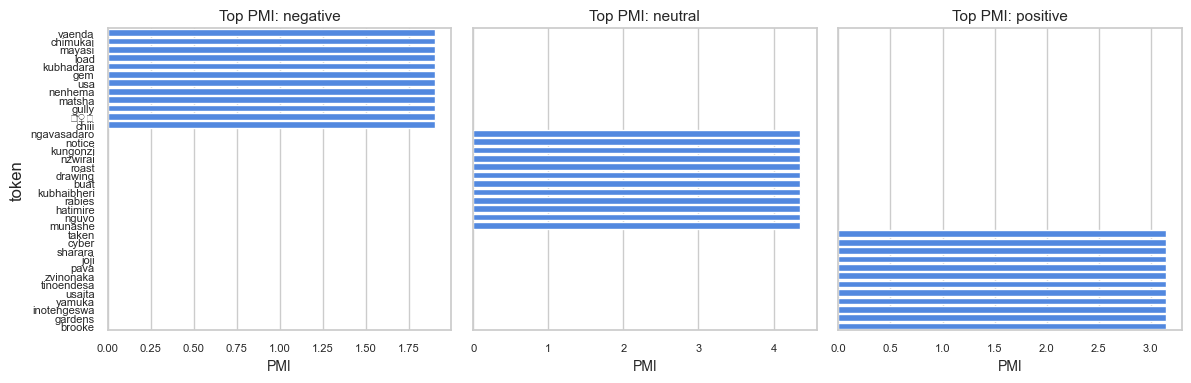

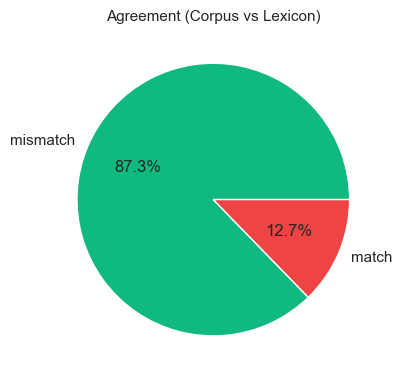

In [16]:
# === Cell J: Plots (top-K bars and pie chart)
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")  # balanced sizing

# ===Filter noisy tokens for neater charts ===
TOP_K_PLOT = 12        # how many bars per class to show
MIN_TOKEN_LEN = 3      # drop super-short items
EXCLUDE_PATTERNS = [r"^@", r"^#",
                    r"^https?://", r"\.com\b",  # urls
                    r"^\d+$"]                   # pure numbers

def looks_noisy(tok: str) -> bool:
    if tok is None: return True
    tok = str(tok).strip().lower()
    if len(tok) < MIN_TOKEN_LEN: return True
    if any(re.search(p, tok) for p in EXCLUDE_PATTERNS): return True
    return False

cands_clean = cands[~cands["token"].map(looks_noisy)].copy()

# NOTE: remove exact duplicates across classes keeping highest PMI
cands_clean = (cands_clean
               .sort_values("PMI", ascending=False)
               .drop_duplicates(subset=["token"], keep="first"))

# === Bar charts: top-K per label (negative / neutral / positive) ===
labels_in_order = ["negative", "neutral", "positive"]  # keeps columns aligned visually
fig, axes = plt.subplots(1, len(labels_in_order), figsize=(14, 4), sharey=True)

for ax, lbl in zip(axes, labels_in_order):
    sub = cands_clean[cands_clean["label"] == lbl]
    top = sub.nlargest(TOP_K_PLOT, "PMI").iloc[::-1]  # reverse so biggest is at top
    sns.barplot(data=top, x="PMI", y="token", ax=ax, color="#3b82f6")
    ax.set_title(f"Top PMI: {lbl}", fontsize=11)
    ax.set_xlabel("PMI", fontsize=10)
    ax.set_ylabel("token" if ax is axes[0] else "")
    # smaller ticklabels to avoid overlap
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)

plt.tight_layout()
plt.subplots_adjust(left=0.22)  # more room for token labels
plt.savefig(RESULTS / "fig_top_pmi_terms.png", dpi=150)

#  ===Agreement pie (match vs mismatch)===
try:
    counts = merged_en["agreement"].value_counts(dropna=False)
    plt.figure(figsize=(4.2, 4.2))
    plt.pie(counts.values,
            labels=counts.index.astype(str),
            autopct="%1.1f%%",
            colors=["#10b981", "#ef4444", "#9ca3af"])
    plt.title("Agreement (Corpus vs Lexicon)", fontsize=11)
    plt.tight_layout()
    plt.savefig(RESULTS / "fig_agreement_pie.png", dpi=150)
    print("Saved figures →", RESULTS)
except Exception as e:
    print("Skipping pie chart (need merged_en):", e)

# Deliverables :
for p in [
    RESULTS/"pmi_candidates.csv",
    RESULTS/"pmi_terms_with_english.csv",
    RESULTS/"corpus_vs_lexicon_matches_enpivot.csv",
    RESULTS/"rag_review_queue_enpivot.csv",
    RESULTS/"fig_top_pmi_terms.png",
    RESULTS/"fig_agreement_pie.png",
]:
    print(("YES" if p.exists() else "NO"), p)